# ResNet

### Setup
Import libraries

In [1]:
import torch, torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Preprocessing
Transform each image according to ResNet34 preprocessing:
1. Resize to 256x256
2. Central crop to 224x224
3. Rescale pixels to 0.0-1.0
4. Normalize pixels using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

In [2]:
class Data(Dataset):
    def __init__(self):
        transformed_img_list = []
        class_list = []
        transform = models.ResNet34_Weights.DEFAULT.transforms()
        for id, city in enumerate(tqdm(['Paris', 'Toronto', 'LosAngeles'])):
            for i in range(300):
                path = '../../images/' + city + 'Resized/' + str(i) + '.png'
                if os.path.isfile(path):
                    img = Image.open(path)
                    transformed_img_list.append(transform(img))
                    class_list.append(id)
        
        self.x = torch.stack(transformed_img_list, dim=0)
        print(self.x.shape)
        self.y = torch.tensor(class_list)
        self.len = len(self.x)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

In [3]:
dset = Data()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s]


torch.Size([616, 3, 224, 224])


### Training
Load a pretrained ResNet34 model and change its FC layer to predict 3 classes instead. Using 80% of the data, the model is trained for 10 epochs with a mini-batch size of 32. The best-performing model has its parameters saved

In [4]:
resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = nn.Linear(512, 3)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
train_set, val_set = random_split(dset, [0.8, 0.2])
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1)
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4)

In [6]:
loss_list = []
acc_list = []
best_acc = 0
file = os.path.join(os.getcwd(), 'resnet.pt')
for epoch in tqdm(range(10)):
    loss_sublist = []
    resnet.train()
    for X, y in train_loader:
        z = resnet(X)
        loss = criterion(z, y)
        loss_sublist.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    loss_list.append(np.mean(loss_sublist))

    correct = 0
    resnet.eval()
    for X, y in val_loader:
        z = resnet(X)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y).sum().item()
    accuracy = correct / len(val_set)
    acc_list.append(accuracy)
    if accuracy > best_acc:
        torch.save(resnet.state_dict(), file)
        best_acc = accuracy
    
    print('epoch '+str(epoch)+' loss: '+str(np.mean(loss_sublist)))
    print('epoch '+str(epoch)+' accuracy: '+str(accuracy))

 10%|████████▎                                                                          | 1/10 [00:58<08:50, 58.95s/it]

epoch 0 loss: 1.0690435096621513
epoch 0 accuracy: 0.44715447154471544


 20%|████████████████▌                                                                  | 2/10 [01:58<07:53, 59.13s/it]

epoch 1 loss: 0.835942480713129
epoch 1 accuracy: 0.6260162601626016


 30%|████████████████████████▉                                                          | 3/10 [02:56<06:52, 58.88s/it]

epoch 2 loss: 0.7160706557333469
epoch 2 accuracy: 0.6422764227642277


 40%|█████████████████████████████████▏                                                 | 4/10 [03:55<05:52, 58.70s/it]

epoch 3 loss: 0.6157381031662226
epoch 3 accuracy: 0.6910569105691057


 50%|█████████████████████████████████████████▌                                         | 5/10 [04:53<04:52, 58.48s/it]

epoch 4 loss: 0.5761432759463787
epoch 4 accuracy: 0.7560975609756098


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [05:52<03:54, 58.71s/it]

epoch 5 loss: 0.5355790164321661
epoch 5 accuracy: 0.7560975609756098


 70%|██████████████████████████████████████████████████████████                         | 7/10 [06:51<02:56, 58.71s/it]

epoch 6 loss: 0.5218726247549057
epoch 6 accuracy: 0.7723577235772358


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [07:51<01:58, 59.21s/it]

epoch 7 loss: 0.544185807928443
epoch 7 accuracy: 0.7560975609756098


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [08:49<00:58, 58.97s/it]

epoch 8 loss: 0.5253735389560461
epoch 8 accuracy: 0.7560975609756098


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [09:47<00:00, 58.80s/it]

epoch 9 loss: 0.5335785578936338
epoch 9 accuracy: 0.7479674796747967


### Evaluation
Load in the best-performing model. First show the confusion matrix on the testing data (20% of total data)

C:\Users\joshu\AppData\Local\Temp\ipykernel_18860\3192371911.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load(file))


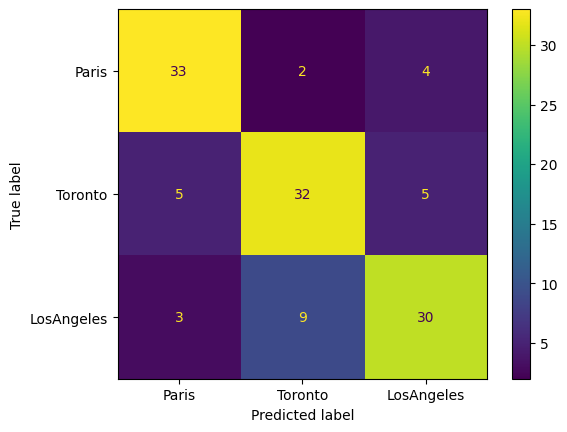

In [7]:
resnet = models.resnet34()
resnet.fc = nn.Linear(512, 3)
resnet.load_state_dict(torch.load(file))
y_test = []
y_pred = []
resnet.eval()
for X, y in val_loader:
    z = resnet(X)
    _, yhat = torch.max(z.data, 1)
    y_pred.append(yhat.item())
    y_test.append(y.item())
conf_matrix = confusion_matrix(y_test, y_pred)
conf_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Paris', 'Toronto', 'LosAngeles'])
conf_disp.plot()
plt.show()

Let's take a look at how the model performed after each epoch

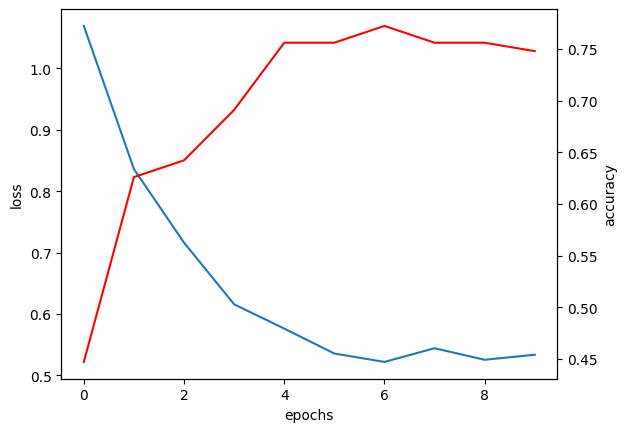

In [8]:
fig, ax1 = plt.subplots()

ax1.plot(list(range(10)), loss_list)
ax1.set_ylabel('loss')
ax1.set_xlabel('epochs')

ax2 = ax1.twinx()
ax2.plot(list(range(10)), acc_list, color='red')
ax2.set_ylabel('accuracy')

plt.show()